In [29]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import ffn
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: xlabel='Date'>

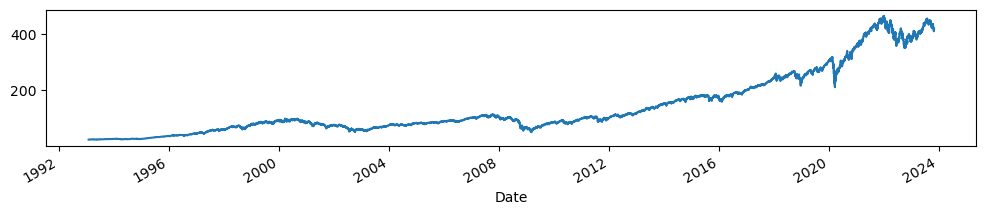

In [16]:
data = ffn.get('spy')
data = data["spy"]

rets = data.pct_change()

data.plot(figsize=(12,2))

In [17]:
"""
Idee:
setze n als Parameter n_max und bekomme dann die Barriers für ein gegebenes n, weil ja eigentlich die Barriers für 21*6 auch die Werte von 21*3 benutzen könnten

"""

def triple_barrier_method(rets, n, barrier, labels=None, center=False):
    """
    Apply the Triple Barrier Method to financial returns data by Marcos López de Prado.

    Parameters:
    rets (pandas.Series): Series of returns.
    n (int): Window size for the barrier method.
    barrier (float): Barrier value for determining the hit.
    labels (list, optional): Labels for the barrier hit outcomes. Starting from (double) negative, to neutral, to (double) positive signals. Defaults to [-2, -1, 0, 1, 2]. 
    center (bool, optional): Center the returns by their mean to denominate an above average return. Defaults to False.

    Returns:
    pandas.Series: Series of labeled outcomes based on barrier hits.
    """
    # Set default labels if None are provided
    if labels is None:
        labels = [-2, -1, 0, 1, 2]

    # Calculate the cumulative return for different windows.
    # This will be used to check which barrier has been hit first
    cumulative_returns = {}
    for i in range(1, n+1):
        cumulative_returns[i] = np.exp(np.log(rets + 1).rolling(i).sum().shift(-i)) - 1
    cumulative_returns = pd.DataFrame(cumulative_returns)

    # Center data
    if center:
        cumulative_returns = cumulative_returns - cumulative_returns.expanding().mean()

    # We use numeric values as label as first since we need to find the minimum later.
    conditions = {
        # Negative barriers
        -2: lambda x: (x <= -2*barrier),   
        -1 : lambda x: (x > -2*barrier) & (x <= -1*barrier),
        # Neutral will be detected later if no other barrier has been hit
        # Positive barriers
        1 : lambda x: (x > 1*barrier) & (x <= 2*barrier),
        2: lambda x: (x > 2*barrier),
    }

    triple_barrier = {}
    for label, cond in conditions.items():
        # Check if the condition has been met inside the rolling window of cumulative returns, columns are range(n) for the cumulative return window
        triple_barrier[label] = cond(cumulative_returns)
        # For each barrier, get the first i in range(n) that crossed it. Replace False with np.nan to detect the first crossing by checking for not-missing values
        # columns: [-2, -1, 1, 2] as names for the respective barriers
        triple_barrier[label] = triple_barrier[label].replace(False, np.nan).apply(pd.Series.first_valid_index, axis=1)
    triple_barrier = pd.DataFrame(triple_barrier)

    # If the double barrier has been hit, remove the hit detection for the first barrier
    triple_barrier.loc[triple_barrier[2].notna(), 1] = np.nan
    triple_barrier.loc[triple_barrier[-2].notna(), -1] = np.nan

    # Idxmin to identify which barrier has been hit first
    # No barrier hit results in a missing => fillna(0)
    triple_barrier = triple_barrier.idxmin(axis=1).fillna(0).astype(int)
    triple_barrier.iloc[-n:] = np.nan  # correct for fill-na, future results are correctly missing

    label_replacement = dict(zip([-2, -1, 0, 1, 2], labels))
    triple_barrier = triple_barrier.replace(label_replacement)

    return triple_barrier

In [ ]:
n = 21*6
triple_barriers = {}
barriers_to_check = 1000
max_barrier = data.pct_change(n).abs().max()

def process_barrier(barrier):
    try:
        _current_labels = triple_barrier_method(rets, n=n, barrier=barrier, center=False)
        if _current_labels.nunique() == 5:
            return barrier, _current_labels
    except Exception as e:
        pass
    return None

results = Parallel(n_jobs=-1, prefer="threads")(delayed(process_barrier)(barrier) for barrier in tqdm(np.linspace(0.001, max_barrier, barriers_to_check)))
results = [result for result in results if result is not None]
triple_barriers = {barrier: labels for barrier, labels in results if labels is not None}
triple_barriers = pd.DataFrame(triple_barriers)
triple_barriers.columns = [round(c, 6) for c in triple_barriers.columns]

# Tests

In [41]:
from scipy import stats

test_metrics = {}
for distribution in ["norm", "uniform"]:
    test_metrics[distribution] = triple_barriers.dropna().apply(lambda x: stats.kstest(x, distribution)).T[0]
test_metrics = pd.DataFrame(test_metrics)

counts_by_barrier = triple_barriers.apply(lambda x: x.value_counts(normalize=True)).T.fillna(0)

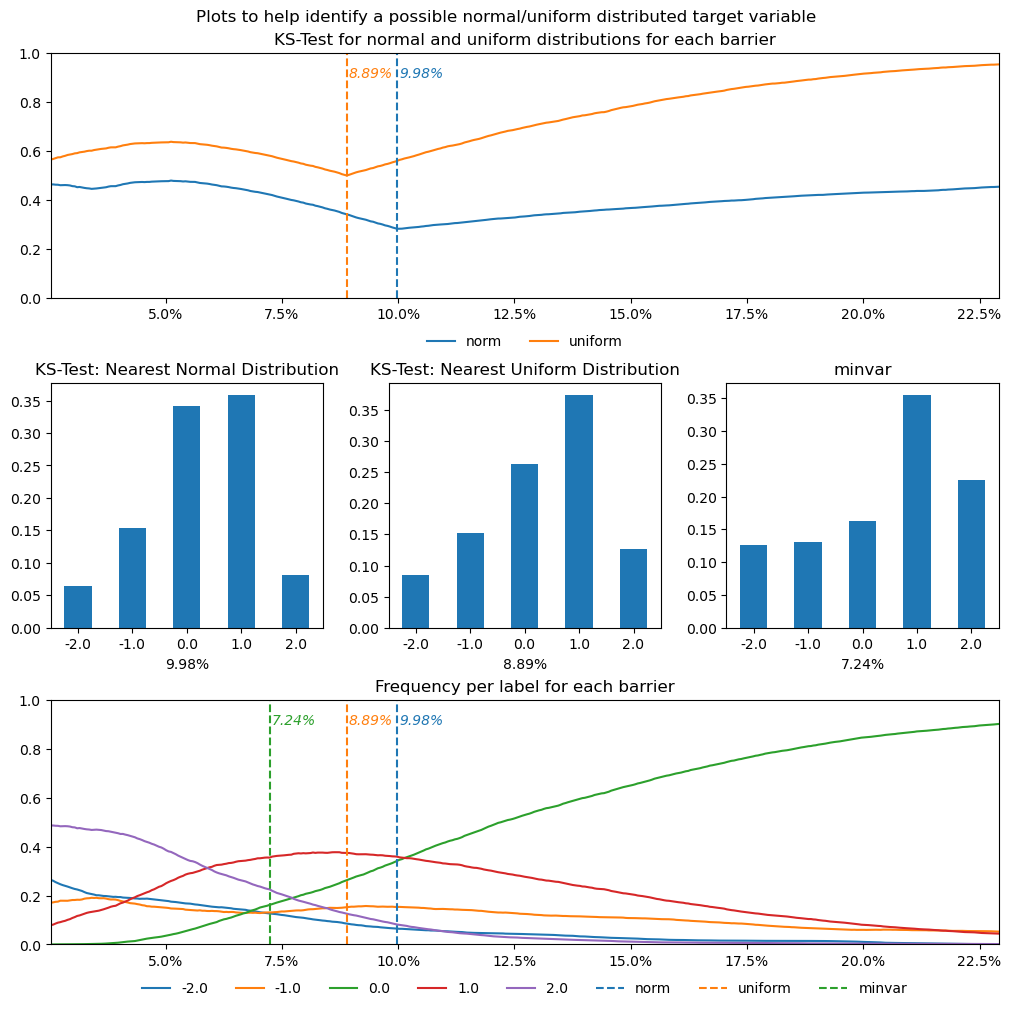

In [42]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

idx_norm = test_metrics["norm"].idxmin()
idx_uniform = test_metrics["uniform"].idxmin()
idx_minvar = counts_by_barrier.std(axis=1).idxmin()


fig = plt.figure(layout="constrained", figsize=(10,10))
fig.suptitle("Plots to help identify a possible normal/uniform distributed target variable")

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])
ax3 = fig.add_subplot(gs[-1, :])

# ----- Plot 1 -----

test_metrics.plot(ax=ax1, title="KS-Test for normal and uniform distributions for each barrier")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=test_metrics.shape[1], frameon=False)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax1.axvline(idx_norm, ls="--", c="#1f77b4")
ax1.text(idx_norm + 0.0005, 0.9, format(idx_norm, ".2%"), style='italic', c="#1f77b4")

ax1.axvline(idx_uniform, ls="--", c="#ff7f0e")
ax1.text(idx_uniform + 0.0005, 0.9, format(idx_uniform, ".2%"), style='italic', c="#ff7f0e")

ax1.set_ylim(0, 1)
ax1.set_xlim(test_metrics.index.min(), test_metrics.index.max())

# ----- Plot 2 -----

triple_barriers[idx_norm].rename(format(idx_norm, ".2%")).value_counts(normalize=True).sort_index().plot.bar(
    rot=0, title="KS-Test: Nearest Normal Distribution", ax=ax21
)

triple_barriers[idx_uniform].rename(format(idx_uniform, ".2%")).value_counts(normalize=True).sort_index().plot.bar(
    rot=0, title="KS-Test: Nearest Uniform Distribution", ax=ax22
)

triple_barriers[idx_minvar].rename(format(idx_minvar, ".2%")).value_counts(normalize=True).sort_index().plot.bar(
    rot=0, title="minvar", ax=ax23
)

# ----- Plot 3 -----

counts_by_barrier.plot(ax=ax3, title="Frequency per label for each barrier")
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.axvline(idx_norm, label="norm", ls="--", c="#1f77b4")
ax3.text(idx_norm + 0.0005, 0.9, format(idx_norm, ".2%"), style='italic', c="#1f77b4")

ax3.axvline(idx_uniform, label="uniform", ls="--", c="#ff7f0e")
ax3.text(idx_uniform + 0.0005, 0.9, format(idx_uniform, ".2%"), style='italic', c="#ff7f0e")

ax3.axvline(idx_minvar, label="minvar", ls="--", c="#2ca02c")
ax3.text(idx_minvar + 0.0005, 0.9, format(idx_minvar, ".2%"), style='italic', c="#2ca02c")

ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=counts_by_barrier.shape[1] + 3, frameon=False)
ax3.set_ylim(0, 1)
ax3.set_xlim(test_metrics.index.min(), test_metrics.index.max())
plt.show()

In [43]:
distributions = {
    "norm": test_metrics["norm"].idxmin(),
    "uniform": test_metrics["uniform"].idxmin(),
    "minvar": counts_by_barrier.std(axis=1).idxmin()
}

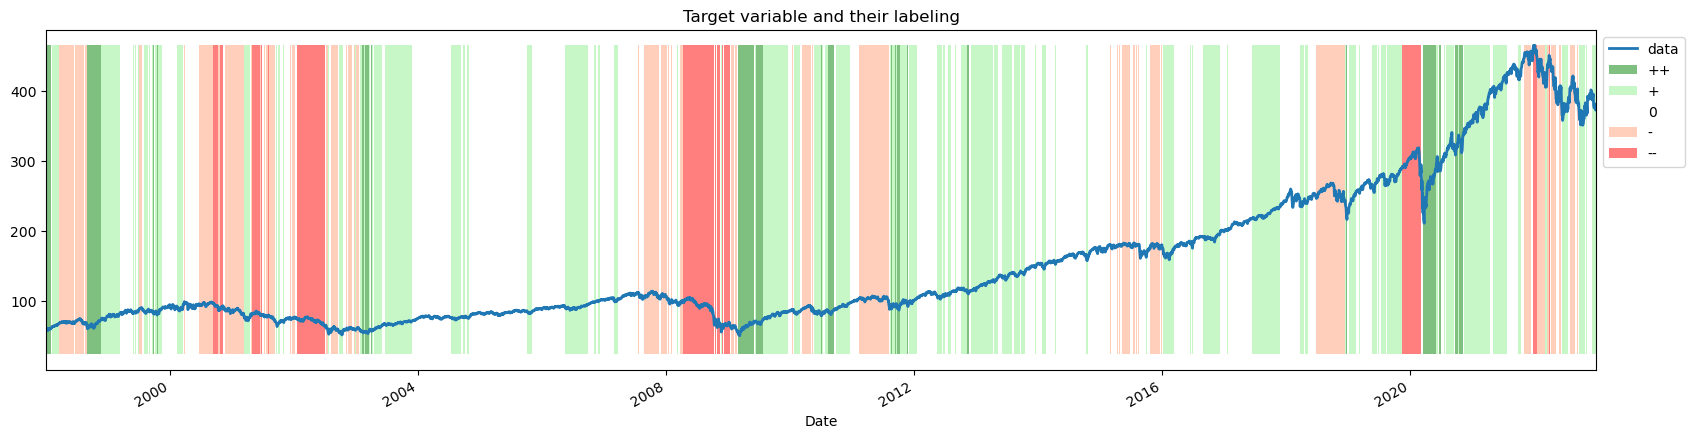

In [46]:
labels = triple_barriers[distributions["norm"]].replace({-2: "--", -1: "-", 0: "0", 1: "+", 2: "++"}).rename("label")
label_order = ["--", "-", "0", "+", "++"]
idx = labels.index.intersection(data.index)

plot_df = pd.concat([data.rename("data"), labels.rename("label")], axis=1).loc[idx].dropna()

figsize = (20, 5)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title("Target variable and their labeling")
plot_df["data"].plot(ax=ax, linewidth=2)
ylim = (plot_df["data"].min(), plot_df["data"].max())
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="++",facecolor='green', alpha=0.5, label="++")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="+",facecolor='lightgreen', alpha=0.5, label="+")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="0",facecolor='white', alpha=0.5, label="0")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="-",facecolor='lightsalmon', alpha=0.5, label="-")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="--",facecolor='red', alpha=0.5, label="--")
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlim((pd.Timestamp("1998-01-01"), pd.Timestamp("2023-01-01")))
plt.show()

In [48]:
transition_counts = labels.groupby([labels.rename("From"), labels.shift(-1).rename("To")]).size()

# Calculate transition probabilities
transition_probabilities = transition_counts.groupby(level=0).apply(lambda x: x / x.sum())
transition_probabilities = transition_probabilities.unstack().droplevel(1).fillna(0).loc[label_order, label_order]

print(f"Changes per year: {(labels != labels.shift()).groupby(labels.index.year).sum().mean().round(2)}")
transition_probabilities.style.format( "{:.1%}")

Changes per year: 24.74


To,--,-,0,+,++
From,,,,,
--,93.5%,5.1%,0.0%,1.4%,0.0%
-,2.0%,91.3%,4.5%,1.7%,0.6%
0,0.0%,2.2%,92.5%,5.3%,0.0%
+,0.3%,0.6%,5.2%,91.4%,2.5%
++,0.0%,0.6%,0.0%,11.6%,87.8%


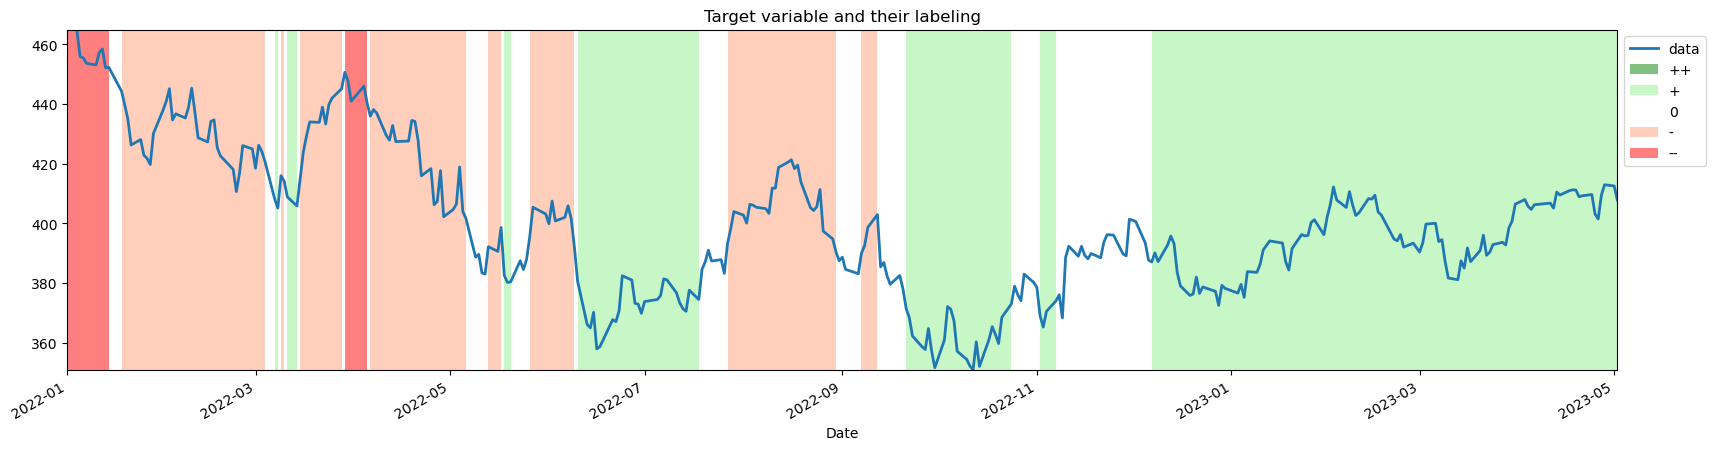

In [49]:
labels = triple_barriers[distributions["norm"]].replace({-2: "--", -1: "-", 0: "0", 1: "+", 2: "++"}).rename("label")
label_order = ["--", "-", "0", "+", "++"]
idx = labels.index.intersection(data.index)

plot_df = pd.concat([data.rename("data").pct_change(n).shift(-n), labels.rename("label")], axis=1).loc[idx].dropna()
plot_df = pd.concat([data.rename("data"), labels.rename("label")], axis=1).loc[idx].dropna()


start_date = pd.Timestamp("2022-01-01")
end_date = pd.Timestamp("2023-10-01")

start_date, end_date = max(start_date, plot_df.index.min()), min(end_date, plot_df.index.max())

figsize = (20, 5)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title("Target variable and their labeling")
line = plot_df["data"].loc[start_date:end_date]
ylim = (line.min(), line.max())
line.plot(ax=ax, linewidth=2)
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="++",facecolor='green', alpha=0.5, label="++")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="+",facecolor='lightgreen', alpha=0.5, label="+")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="0",facecolor='white', alpha=0.5, label="0")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="-",facecolor='lightsalmon', alpha=0.5, label="-")
ax.fill_between(plot_df["data"].index, ylim[0], ylim[1], where=plot_df["label"]=="--",facecolor='red', alpha=0.5, label="--")
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlim((start_date, end_date))
ax.set_ylim(ylim)
plt.show()